Implementing an Autoencoder in PyTorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The primary differences are that the network is much larger (as the code is designed to work with much larger images) and the model is split into two parts to allow for differential encode/decode metrics such as Mahalanobis Distance.

This version of the model is designed with a convolutional model.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import math
import numpy
import collections
import gc

from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
import os

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
#seed = 42
seed = 2521
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
print(platform)

print("memory at beginning of run")
GPUtil.showUtilization()

cuda
memory at beginning of run
| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 512
height = 512

image_size = width * height

batch_size = 20
epochs = 500
#epochs = 2
learning_rate = 1e-5
l2_decay = 0.0

dropout_rate = 0.1

#code_size = 100
#code_sides = [10,11,12,13,14,15,16]
code_sides = [12]

#convolution_filters = [4,5,6,7,8]
convolution_filters = [5]

#image_count = 200
image_count = -1

validation_split = 0.9

early_stopping_bracket = 15
early_stopping_forgiveness = 6

## Dataset

Using a custom dataset class to load the images:

In [4]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("F")
        tensor_image = self.transform(image)
        return tensor_image

In [5]:
from torchvision.transforms import ToTensor,Grayscale
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/512"
#train_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)
train_dataset = CustomDataSet(root_dir, transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

dataset_len = len(train_dataset_subset)
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor((1.0 - validation_split) * dataset_len))

dataset_size = len(train_dataset_subset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
    
train_loader = torch.utils.data.DataLoader(
    train_dataset_subset, batch_size=batch_size, sampler = train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    train_dataset_subset, batch_size=batch_size, sampler = valid_sampler
)

data_loaders = {"train": train_loader, "val": valid_loader}
data_lengths = {"train": split, "val": val_len}
print(split)
print(val_len)

3309
367


In [6]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
run_device = torch.device(platform)
store_device = torch.device("cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu

models = []
optimizers = []

print("memory before model construction")
GPUtil.showUtilization()

for i in range(len(code_sides)):
    models.append([])
    optimizers.append([])
    code_size = code_sides[i] * code_sides[i]
    for j in range(len(convolution_filters)):
        filters =  convolution_filters[j]
        new_model = SplitAutoencoder(input_shape=(height,width),code_size=code_size,convolutions=filters,dropout_chance=dropout_rate).to(store_device)
        models[i].append(new_model)
        optimizers[i].append(optim.Adam(new_model.parameters(), weight_decay=l2_decay, lr=learning_rate))

print("memory after model construction")
GPUtil.showUtilization()
# mean-squared error loss
#criterion = nn.MSELoss(reduction='sum')
criterion = nn.MSELoss(reduction='mean')
#criterion = nn.BCELoss()

memory before model construction
| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |
memory after model construction
| ID | GPU | MEM |
------------------
|  0 |  0% |  4% |


We use a grid parameter search method to train our autoencoder for our specified number of epochs for each combination of code sizes and convolutional filters

In [7]:
best_model_dicts = []
# populate with fake best models
for i in range(len(code_sides)):
    best_model_dicts.append([])
    for j in range(len(convolution_filters)):
        best_model_dicts[i].append((65535.0,None))
print(best_model_dicts)

[[(65535.0, None)]]


In [8]:
train_losses = []
val_losses = []

batch_features_n = torch.empty(batch_size, 1, width, height, dtype=torch.float32)
for i in range(len(code_sides)):
    train_losses.append([])
    val_losses.append([])

    for j in range(len(convolution_filters)):
        print("==================")
        
        print("Running for code size:" + str(code_sides[i] * code_sides[i]) + " and filter size:"+str(convolution_filters[j]))

        train_losses[i].append([])
        val_losses[i].append([])
        
        early_stopping_hits = 0

        try:
            model_n = models[i][j].to(run_device)
            if torch.cuda.device_count() > 1:
                model_n = nn.DataParallel(model_n)
            optimo = optim.Adam(model_n.parameters(), weight_decay=l2_decay, lr=learning_rate)
            for epoch in range(epochs):
                losses = {'train':0.0, 'val':0.0}

                for phase in ['train', 'val']:
                    if phase == 'train':
                        model_n.train()  # Set model to training mode
                    else:
                        model_n.eval()  # Set model to evaluate mode

                    for batch_features in data_loaders[phase]:
                        # load it to the active device
                        batch_features_n = batch_features.to(run_device)

                        # reset the gradients back to zero
                        # PyTorch accumulates gradients on subsequent backward passes
                        optimo.zero_grad()

                        # compute reconstructions
                        codes = model_n.encoder(batch_features_n)
                        outputs = model_n.decoder(codes)

                        # compute training reconstruction loss
                        local_loss = criterion(outputs,batch_features_n)

                        if phase == 'train':
                            # compute accumulated gradients
                            local_loss.backward()

                            # perform parameter update based on current gradients
                            optimo.step()

                        # add the mini-batch training loss to epoch loss
                        losses[phase] += local_loss.item()
                        
                        del local_loss
                        del codes
                        del outputs


                # compute the epoch training loss

                losses['train'] = losses['train'] / len(data_loaders['train'])
                losses['val'] = losses['val'] / len(data_loaders['val'])

                #check if best model
                if(losses['val'] < best_model_dicts[i][j][0]):
                    print("new best!")
                    model_dict = {}
                    for k, v in model_n.state_dict().items():
                          model_dict[k] = v.cpu()
                    best_model_dicts[i][j] = (losses['val'],model_dict)

                train_losses[i][j].append(losses['train'])
                val_losses[i][j].append(losses['val'])
                
                # display the epoch training loss
                print("epoch : {}/{}, train loss = {:.8f}, validation loss = {:.8f}".format(epoch + 1, epochs, losses['train'],losses['val']))
                
                #early stopping
                if(epoch>early_stopping_bracket+1):
                    if(val_losses[i][j][epoch-early_stopping_bracket] <= losses['val']):
                        # early stopping situation found. see if we need to stop yet
                        early_stopping_hits = early_stopping_hits + 1
                        if(early_stopping_hits > early_stopping_forgiveness):
                            print("Early stopping!")
                            break
                    else:
                        if(early_stopping_hits > 0):
                            early_stopping_hits = early_stopping_hits - 1
            
            del model_n
            del optimo
            torch.cuda.empty_cache()
        except RuntimeError:
            print("Can't complete this model, skipping...")
            model_n = None
            optimo = None
        
        #absolutely hideous hack but I can't stop the model sticking around otherwise and I have zero idea why

        # kills currently alive Tensors and Parameters on GPU
        #for obj in gc.get_objects():
        #    try:
        #        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)) and obj.is_cuda:
        #            del obj
        #    except:
        #        pass
        #gc.collect()

        print("Memory at model end")
        GPUtil.showUtilization()

print('\a')

Running for code size:144 and filter size:5


C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


new best!
epoch : 1/500, train loss = 0.03883541, validation loss = 0.03517073
new best!
epoch : 2/500, train loss = 0.03436865, validation loss = 0.03313683
new best!
epoch : 3/500, train loss = 0.03324461, validation loss = 0.03269612
new best!
epoch : 4/500, train loss = 0.03258549, validation loss = 0.03197885
new best!
epoch : 5/500, train loss = 0.03188964, validation loss = 0.03164304
new best!
epoch : 6/500, train loss = 0.03162505, validation loss = 0.03133244
new best!
epoch : 7/500, train loss = 0.03133563, validation loss = 0.03110909
new best!
epoch : 8/500, train loss = 0.03108884, validation loss = 0.03094344
new best!
epoch : 9/500, train loss = 0.03076677, validation loss = 0.03026874
new best!
epoch : 10/500, train loss = 0.02988902, validation loss = 0.02941740
new best!
epoch : 11/500, train loss = 0.02884433, validation loss = 0.02761697
new best!
epoch : 12/500, train loss = 0.02675317, validation loss = 0.02610934
new best!
epoch : 13/500, train loss = 0.02542466

Restore the best trained model and save.

In [9]:
print("memory before model restoration")
GPUtil.showUtilization()
#print(best_model_dicts)
for i in range(len(code_sides)):
    for j in range(len(convolution_filters)):
        if(best_model_dicts[i][j][1]!=None):
            print("Restoring best model for "+ str(i) + "/" + str(j));
            models[i][j].load_state_dict(best_model_dicts[i][j][1], )
            PATH = "../../Data/OPTIMAM_NEW/model" + str(i) + "_" + str(j) +".pt"
            torch.save(models[i][j], PATH)

print("memory after model restoration")
GPUtil.showUtilization()

memory before model restoration
| ID | GPU | MEM |
------------------
|  0 | 26% | 36% |
Restoring best model for 0/0
memory after model restoration
| ID | GPU | MEM |
------------------
|  0 |  0% | 36% |


Let's extract some test examples to reconstruct using our trained autoencoder.

In [10]:
test_dataset = CustomDataSet(root_dir, transform) # same transform as we used for the training, for compatibility
#test_dataset = train_dataset_subset
if (image_count == -1):
    test_dataset_subset = test_dataset
else:
    test_dataset_subset = torch.utils.data.Subset(test_dataset, numpy.random.choice(len(test_dataset), image_count, replace=False))

test_loader = torch.utils.data.DataLoader(
    test_dataset_subset, batch_size=5, shuffle=True
)

test_example_sets = []
code_sets = []
reconstruction_sets = []

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

In [11]:
print("memory before testing")
GPUtil.showUtilization()
with torch.no_grad():
    for i in range(len(code_sides)):
        test_example_sets.append([None] * len(convolution_filters))
        code_sets.append([None] * len(convolution_filters))
        reconstruction_sets.append([None] * len(convolution_filters))
        for j in range(len(convolution_filters)):
            if(best_model_dicts[i][j][1]!=None):
                model_t = models[i][j].to(run_device)
                for batch_features in test_loader:
                    test_examples = batch_features.to(run_device)
                    n_codes = model_t.encoder(test_examples)
                    reconstruction = model_t.decoder(n_codes)
                    break;
                test_example_sets[i][j] = test_examples.to(store_device)
                code_sets[i][j] = n_codes.to(store_device)
                reconstruction_sets[i][j] = reconstruction.to(store_device)
                del test_examples
                del n_codes
                del reconstruction
print("memory after testing")
GPUtil.showUtilization()

memory before testing
| ID | GPU | MEM |
------------------
|  0 |  0% | 36% |
memory after testing
| ID | GPU | MEM |
------------------
|  0 |  0% | 39% |


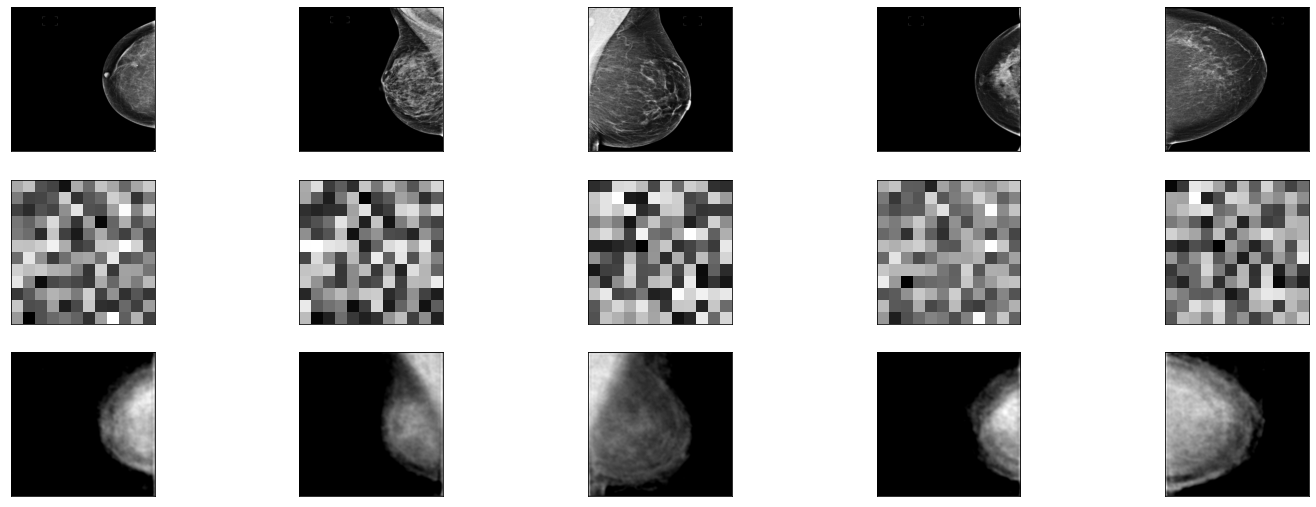

In [12]:
with torch.no_grad():
    for i in range(len(code_sides)):
        for j in range(len(convolution_filters)):
            if(best_model_dicts[i][j][1]!=None):
                number = 5
                plt.figure(figsize=(25, 9))
                for index in range(number):
                    # display original
                    ax = plt.subplot(3, number, index + 1)
                    test_examples = test_example_sets[i][j]
                    copyback = test_examples[index].cpu()
                    #plt.imshow(copyback.numpy().reshape(height, width), vmin=0, vmax=65535)
                    plt.imshow(copyback.reshape(height, width))
                    plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    # display codes
                    ax = plt.subplot(3, number, index + 1 + number)
                    codes = code_sets[i][j]
                    code_copyback = codes[index].cpu()
                    plt.imshow(code_copyback.numpy().reshape(code_sides[i],code_sides[i]))
                    plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    # display reconstruction
                    ax = plt.subplot(3, number, index + 6 + number)
                    reconstruction = reconstruction_sets[i][j]
                    recon_copyback = reconstruction[index].cpu()
                    plt.imshow(recon_copyback.reshape(height, width))
                    plt.gray()
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
                
                out_path = "output"+ str(i) + "_" + str(j) +".png" 
                plt.savefig(out_path)
                #plt.show()